<a href="https://colab.research.google.com/github/aziz122596/Gentex/blob/main/new_method_ovarian_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# Загрузка двух CSV файлов
disease_data = pd.read_csv('/content/merged_datasets.xlsx - disease (1).csv')
health_data = pd.read_csv('/content/merged_datasets.xlsx - health (1).csv')

In [3]:
# Step 2: Data Preprocessing
def preprocess_data(disease_data, health_data):
    # Combine datasets
    combined_data = pd.concat([disease_data, health_data], axis=0)

    # Drop the "Accession" column as it is an identifier
    combined_data = combined_data.drop(columns=["Accession"], errors="ignore")

    # Replace non-numeric values and commas with NaN
    combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)

    # Impute missing values with column mean
    imputer = SimpleImputer(strategy="mean")
    combined_data_imputed = imputer.fit_transform(combined_data)

    # Normalize data
    scaler = MinMaxScaler()
    combined_data_normalized = scaler.fit_transform(combined_data_imputed)

    return combined_data_normalized

# Preprocess the data
processed_data = preprocess_data(disease_data, health_data)

<ipython-input-3-6b1e8f843a3a>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['BENIGN_1' 'BENIGN_2' 'BENIGN_3' 'BENIGN_5' 'BENIGN_7' 'BENIGN_8'
 'MALIGNANT_2' 'MALIGNANT_4' 'MALIGNANT_5' 'MALIGNANT_6' 'MALIGNANT_7'
 'MALIGNANT_8' 'HGSOC_SA01' 'HGSOC_SA02' 'HGSOC_SA04' 'HGSOC_SA05'
 'HGSOC_SA06' 'HGSOC_SA09' 'HGSOC_SA10' 'HGSOC_SA11' 'HGSOC_SA15'
 'HGSOC_SA16' 'HGSOC_SC01' 'HGSOC_SC02' 'HGSOC_SC04' 'HGSOC_SC06'
 'HGSOC_SC08' 'HGSOC_SC10' 'HGSOC_SC15' 'HGSOC_SC16' 'HGSOC_SC17'
 'HGSOC_SC22' 'HGSOC_SC24' 'HGSOC_SC27' 'HGSOC_SC28' 'HGSOC_SC30'
 'HG

In [4]:
# Step 3: Split the data
X_train, X_test = train_test_split(processed_data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [5]:
# Step 4: Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [6]:
# Step 5: Loss Function and Training
def loss_function(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Model hyperparameters
input_dim = X_train.shape[1]
latent_dim = 16
vae = VAE(input_dim, latent_dim)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
batch_size = 64
epochs = 10

# DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_data, _ in train_loader:
        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(batch_data)
        loss = loss_function(reconstructed, batch_data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.2775
Epoch 2/10, Loss: 0.0012
Epoch 3/10, Loss: 0.0008
Epoch 4/10, Loss: 0.0008
Epoch 5/10, Loss: 0.0007
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0008
Epoch 8/10, Loss: 0.0009
Epoch 9/10, Loss: 0.0008
Epoch 10/10, Loss: 0.0006


In [8]:
# Step 6: Evaluate on Test Data
vae.eval()
with torch.no_grad():
    reconstructed, _, _ = vae(X_test_tensor)
    test_loss = loss_function(reconstructed, X_test_tensor, _, _).item()
print(f"Test Loss: {test_loss:.4f}")

# Save the model for future usage
torch.save(vae.state_dict(), "/content/megred/vae_model.pth")

print("Model training complete and saved. Ready for further tasks.")

Test Loss: 0.0086
Model training complete and saved. Ready for further tasks.


In [9]:
# vae.eval()
# with torch.no_grad():
#     reconstructed, _, _ = vae(X_test_tensor)
#     test_loss = loss_function(reconstructed, X_test_tensor, _, _).item()
#     print(f"Test Loss: {test_loss:.4f}")
vae.eval()
with torch.no_grad():
    train_mu, _ = torch.chunk(vae.encoder(X_train_tensor), 2, dim=1)
    test_mu, _ = torch.chunk(vae.encoder(X_test_tensor), 2, dim=1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


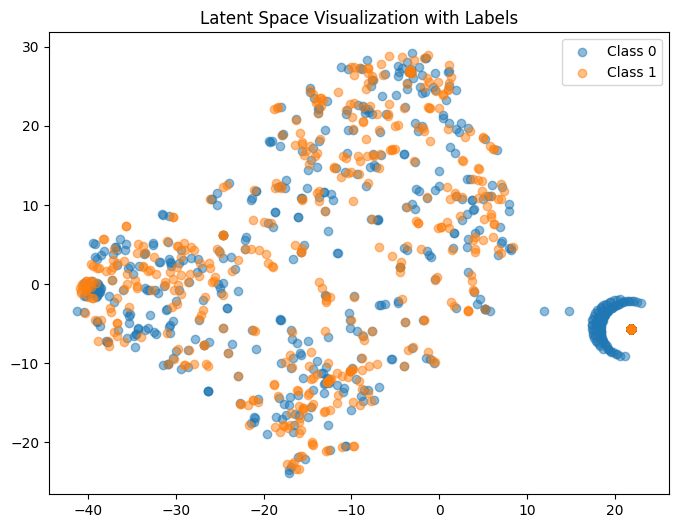

In [11]:
# Ensure labels match the exact number of samples
train_labels = np.array([0] * (train_mu.size(0) // 2) + [1] * (train_mu.size(0) - train_mu.size(0) // 2))
test_labels = np.array([0] * (test_mu.size(0) // 2) + [1] * (test_mu.size(0) - test_mu.size(0) // 2))

# Train logistic regression
clf = LogisticRegression()
clf.fit(train_mu.numpy(), train_labels)

# Predict and evaluate
test_predictions = clf.predict(test_mu.numpy())
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

# Visualize Latent Space
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(test_mu.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[test_labels == 0, 0], latent_2d[test_labels == 0, 1], label="Class 0", alpha=0.5)
plt.scatter(latent_2d[test_labels == 1, 0], latent_2d[test_labels == 1, 1], label="Class 1", alpha=0.5)
plt.title("Latent Space Visualization with Labels")
plt.legend()
plt.show()



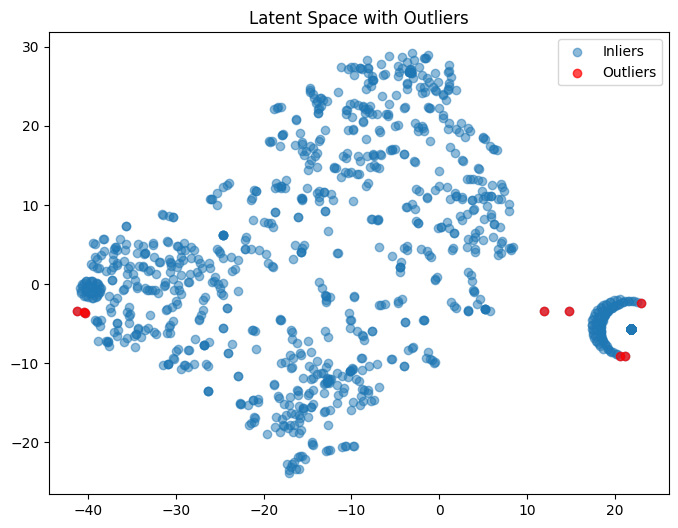

{'Accuracy': 0.49967721110393803,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0}

In [12]:
# Identify Outliers
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(latent_2d)
outliers = latent_2d[outlier_labels == -1]

# Plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], label="Inliers", alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", color="red", alpha=0.7)
plt.title("Latent Space with Outliers")
plt.legend()
plt.show()

# Return classification metrics
classification_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

classification_metrics

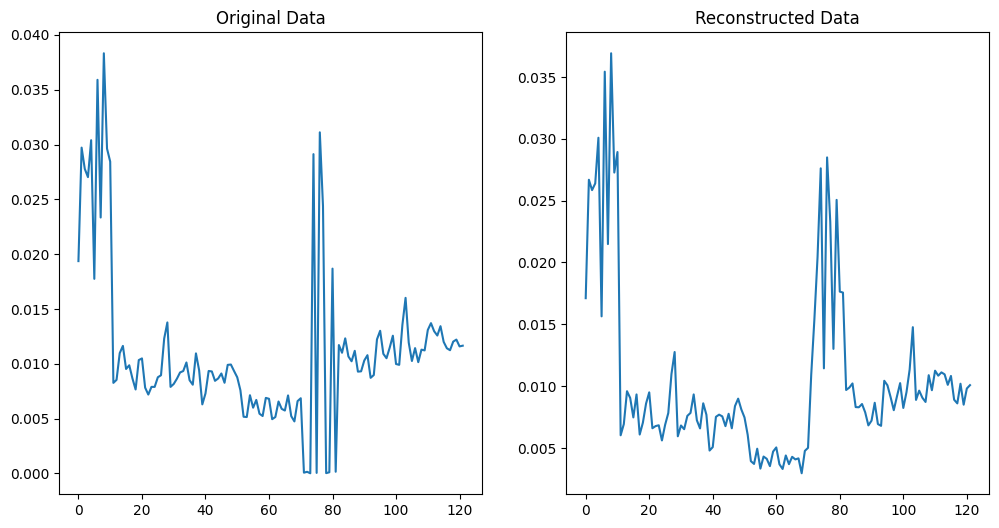

In [ ]:
import matplotlib.pyplot as plt

# Выберите случайный пример из тестовой выборки
idx = np.random.randint(0, X_test_tensor.size(0))
original = X_test_tensor[idx].numpy()
reconstruction = reconstructed[idx].numpy()

# Постройте графики
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.plot(original)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.plot(reconstruction)
plt.show()


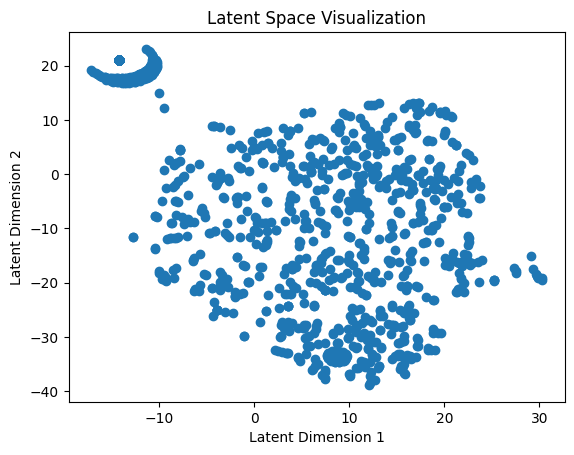

In [ ]:
from sklearn.manifold import TSNE

# Извлеките латентные признаки
with torch.no_grad():
    mu, _ = torch.chunk(vae.encoder(X_test_tensor), 2, dim=1)
latent_features = mu.numpy()

# t-SNE для визуализации
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1])
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()
